## Action Space

- {'steering_angle': -30, 'speed': 0.6},
- {'steering_angle': -15, 'speed': 0.6},
- {'steering_angle': 0, 'speed': 0.6},
- {'steering_angle': 15, 'speed': 0.6},
- {'steering_angle': 30, 'speed': 0.6}

Can be found in "/opt/ml/code/custom_files/agent/model_metadata.json"

In [1]:
%matplotlib notebook

import gym
import numpy as np
import cv2
import matplotlib.pyplot as plt
import deepracer_gym

<IPython.core.display.Javascript object>


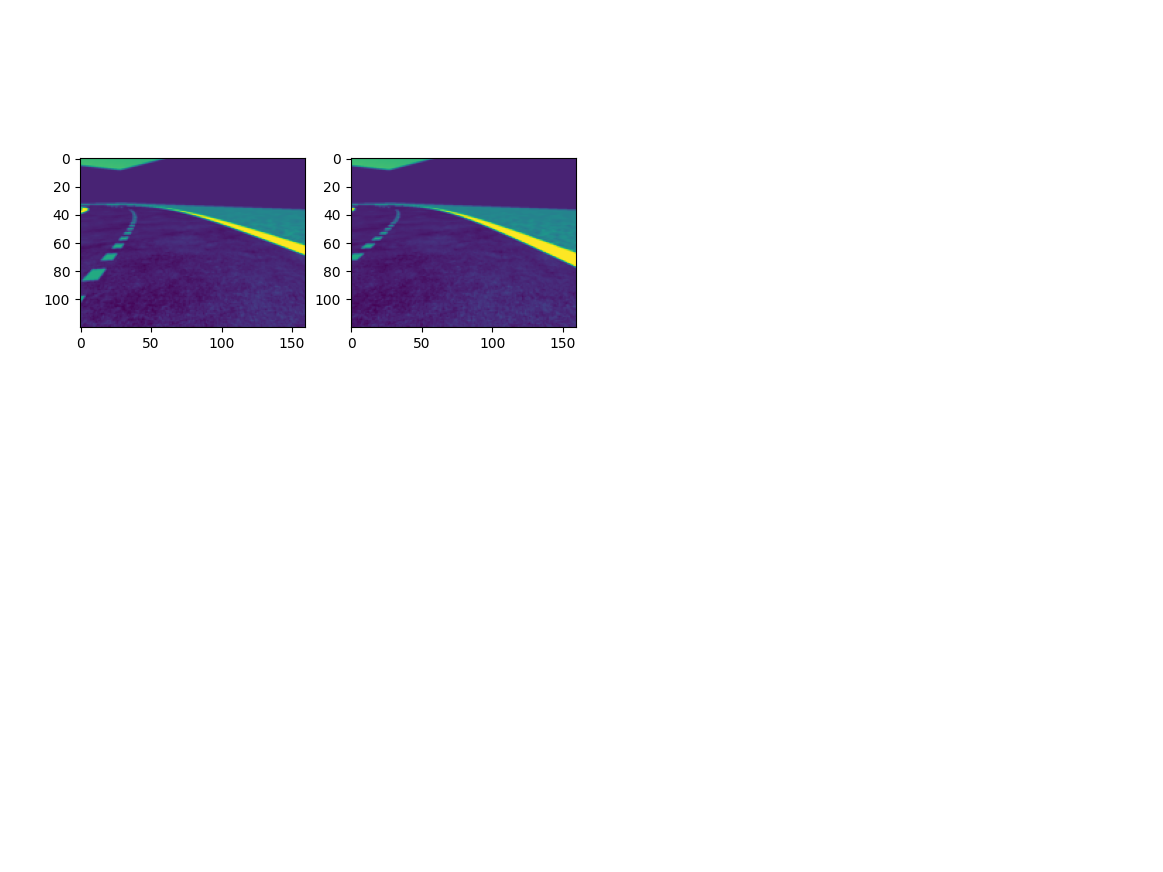

Deepracer Environment Connected succesfully
Episodes Completed: 1 Steps: 47 Reward 26.408000000000023
Episodes Completed: 2 Steps: 30 Reward 12.705999999999994
Episodes Completed: 3 Steps: 46 Reward 28.706000000000017
Episodes Completed: 4 Steps: 30 Reward 11.405999999999993
Episodes Completed: 5 Steps: 39 Reward 16.607000000000014
Episodes Completed: 6 Steps: 52 Reward 23.009000000000032


KeyboardInterrupt: 

In [2]:
fig, axs = plt.subplots(ncols=2)
imgl, imgr = None, None

lefts  = []
rights = []

def render(obs):
    global imgl
    global imgr
    global fig
    
    if not imgl:
        
        imgl = axs[0].imshow(obs['STEREO_CAMERAS'][:,:,0])
        imgr = axs[1].imshow(obs['STEREO_CAMERAS'][:,:,1])
        fig.canvas.draw()
    
    else:
        
        left, right = obs['STEREO_CAMERAS'][:,:,0], obs['STEREO_CAMERAS'][:,:,1]
        
        lefts.append(left)
        rights.append(right)
        
        imgl.set_data(left)
        imgr.set_data(right)
        fig.canvas.draw()
    
env = gym.make('deepracer_gym:deepracer-v0')

obs = env.reset()

print("Deepracer Environment Connected succesfully")

steps_completed = 0
episodes_completed = 0
total_reward = 0

for stp in range(15_000):

    observation, reward, done, info = env.step(2)
    steps_completed += 1 
    total_reward += reward
  
    render(observation)
    
    if done:
        episodes_completed += 1
        print("Episodes Completed:", episodes_completed, "Steps:", steps_completed, "Reward", total_reward)
        steps_completed = 0
        total_reward = 0

## Saving the images

In [3]:
for i, img in enumerate(lefts):
    cv2.imwrite(f'data/left_{i:04}.png', img)
    
for i, img in enumerate(rights):
    cv2.imwrite(f'data/right_{i:04}.png', img)

## Reading images

In [34]:
#img = cv2.imread(f'data/left_0000.png', cv2.IMREAD_GRAYSCALE)
img = cv2.imread("real_road.jpg", cv2.IMREAD_GRAYSCALE)

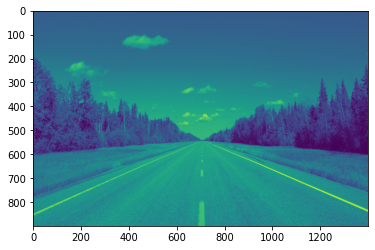

In [35]:
%matplotlib inline
plt.imshow(img)

## Selecting threshold

(100.0, 255.0)

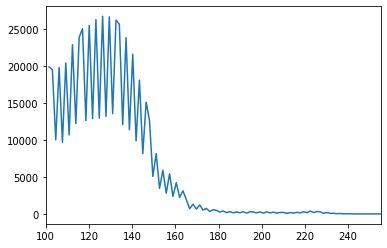

In [36]:
%matplotlib inline
histogram, bin_edges = np.histogram(img, range=(100,255), bins=100)

plt.plot(bin_edges[1:], histogram)
plt.xlim((100,255))

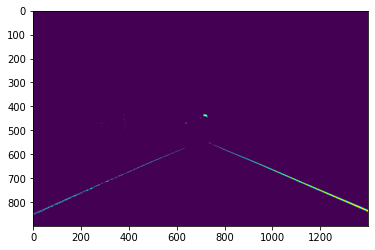

interactive(children=(IntSlider(value=127, description='t', max=255), Output()), _dom_classes=('widget-interac…

In [37]:
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widget

threshold = 200

fig = plt.figure()
image = plt.imshow((img > threshold).astype(float))

@interact(t=(0,255))
def g(t):
    image.set_data((img > t).astype(float))
    fig.canvas.draw_idle()

In [32]:
img = cv2.imread(f'data/left_0160.png', cv2.IMREAD_GRAYSCALE)

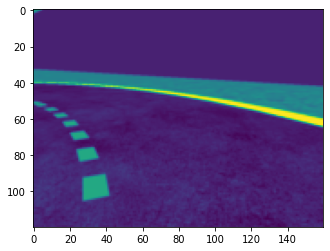

In [9]:
plt.imshow(img)

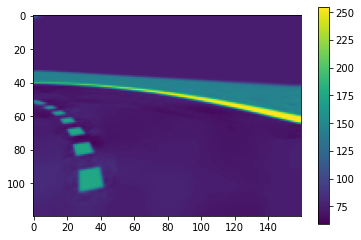

In [10]:
dst = cv2.fastNlMeansDenoising(img.astype('uint8'),20,10,21)

plt.imshow(dst)
plt.colorbar()

(100.0, 255.0)

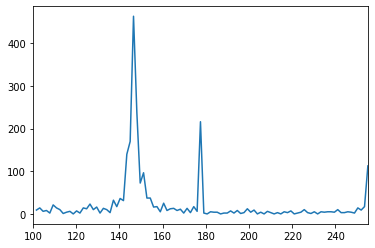

In [11]:
%matplotlib inline

histogram, bin_edges = np.histogram(img, range=(100,255), bins=100)

plt.plot(bin_edges[1:], histogram)
plt.xlim((100,255))

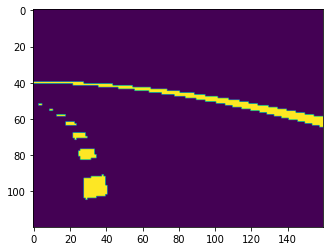

In [12]:
plt.imshow(dst > 160)

## Hough Transform

In [13]:
from skimage import measure
import numpy as np

def keep_long_components(img, threshold=50):
    
    blobs_labels = measure.label(img, background=0)
    kept_labels = []

    for lab in range(1, len(np.unique(blobs_labels))):
        x,y = np.nonzero(np.where(blobs_labels == lab, 1, 0))
        
        if np.max(y) - np.min(y) > threshold:
            kept_labels.append(lab)
            
    return np.where(np.isin(blobs_labels, kept_labels), 255, 0)

In [14]:
%matplotlib inline
def hough(img, minline1, maxline1, minline2, maxline2, init_thresh=200):
    
    new_img = np.copy(img)
    thresholded = (img > init_thresh).astype('uint8')*255
    
    # dilation kernel to select only rotating road on side
    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(thresholded,kernel,iterations = 1)
    long_comp = keep_long_components(dilation)
    img0.set_data(long_comp)
    
    # removing rest to keep only middle road
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(60,7))
    dilation3 = cv2.dilate(long_comp.astype('uint8'),kernel,iterations = 1, borderType = cv2.BORDER_REFLECT)
    center = (((thresholded - dilation3) > 1).astype('float'))
    
    outputImage = cv2.copyMakeBorder(
                center, 
                 50, 
                 50, 
                 50, 
                 50, 
                 cv2.BORDER_CONSTANT, 
                 value=0
              )
    

    kernel = np.ones((50,50),np.uint8)
    middle_road = cv2.morphologyEx(outputImage, cv2.MORPH_CLOSE, kernel)[50:-50, 50:-50]
    img1.set_data(middle_road*255)
    
    # HOUGH for side road
    lines = cv2.HoughLinesP(long_comp.astype('uint8'),10, np.pi/180, 100, minline1, maxline1)
    if lines is not None:
        x1,y1,x2,y2 = np.ravel(lines.mean(axis=0).astype('int32'))

        cv2.line(new_img, (x1, y1), (x2 , y2), 255,10)
        deg_from_horizontal = np.arctan2((y2-y1,1), (x2-x1,0))[0]*180/3.14
        axs[2].set_title(f'Angle from horizontal: {deg_from_horizontal:.2f}')
        
    # HOUGH for middle road
    lines = cv2.HoughLinesP(middle_road.astype('uint8')*255 ,10, np.pi/180, 100, minline2, maxline2)
    if lines is not None:
        x1,y1,x2,y2 = np.ravel(lines.mean(axis=0).astype('int32'))
        cv2.line(new_img,(x1, y1), (x2 , y2), 128, 10)

        
    img2.set_data(new_img)
    
    fig.canvas.draw()

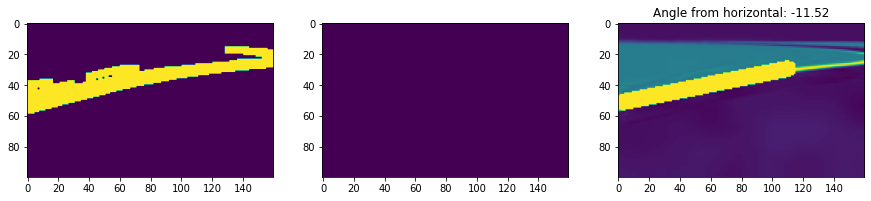

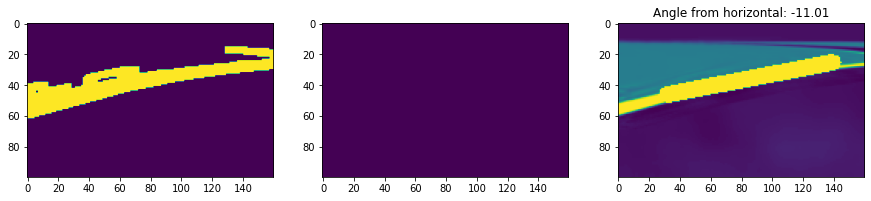

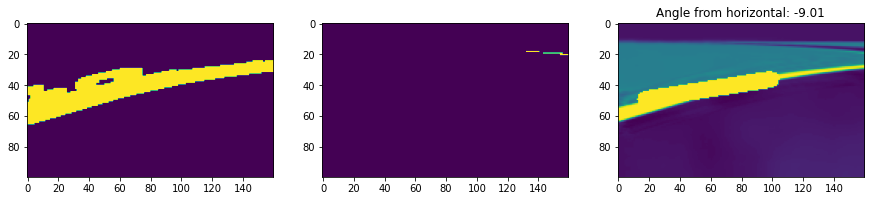

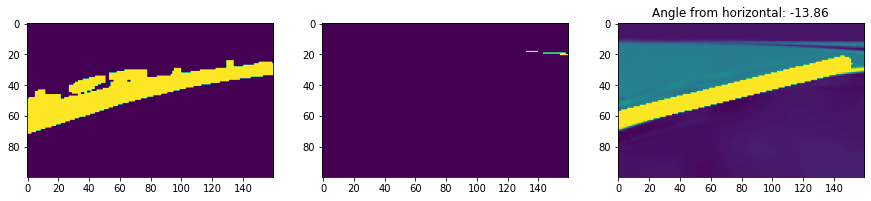

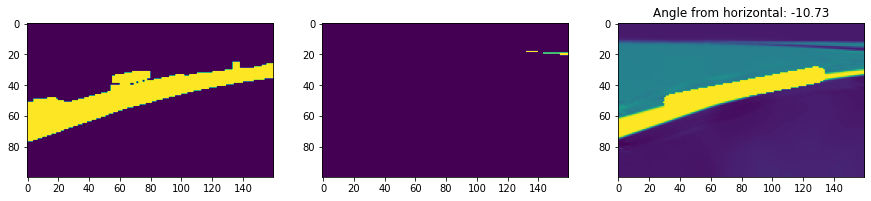

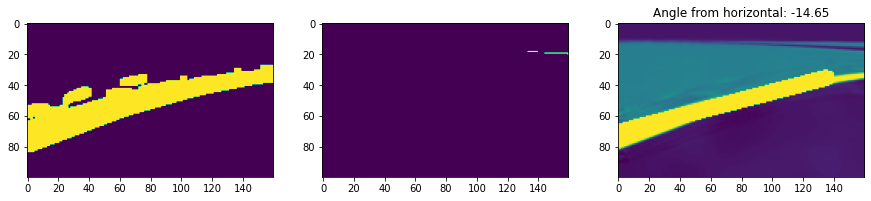

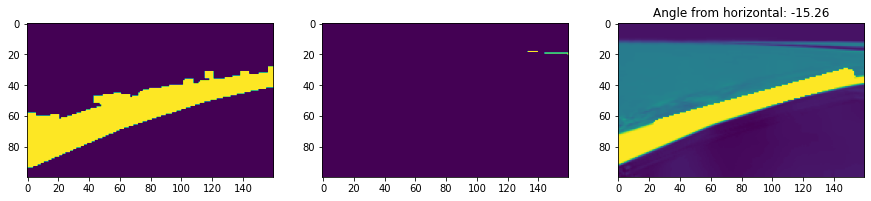

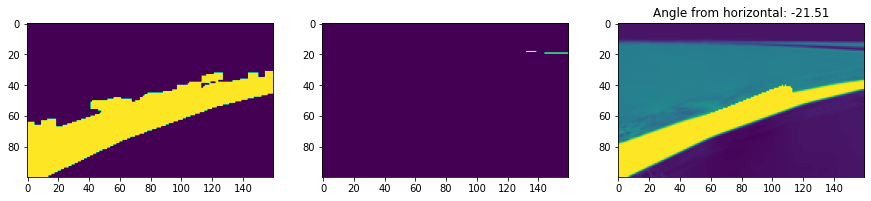

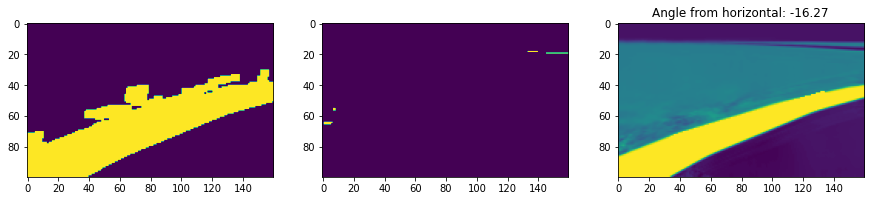

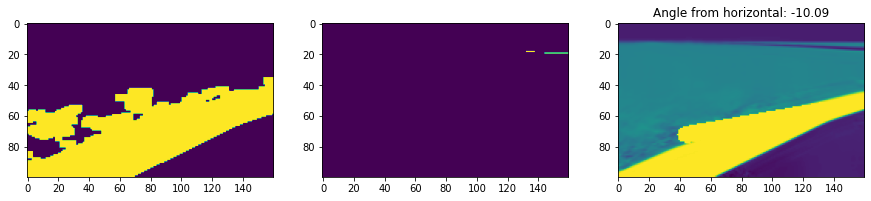

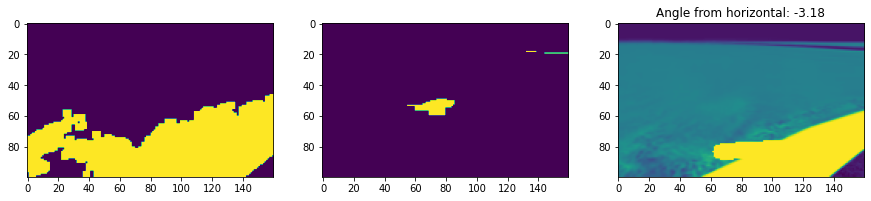

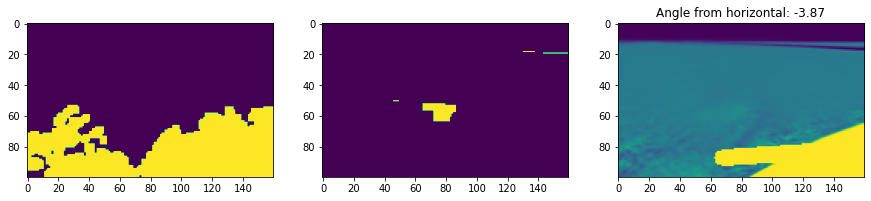

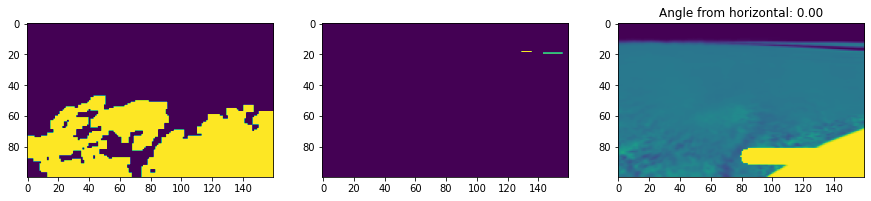

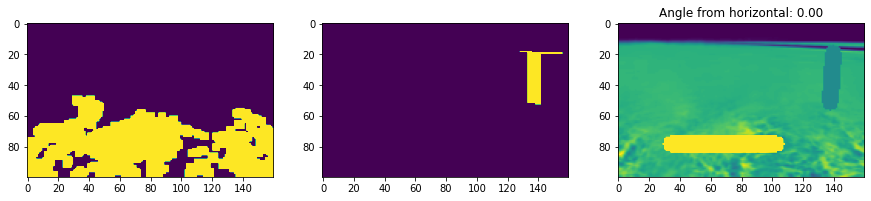

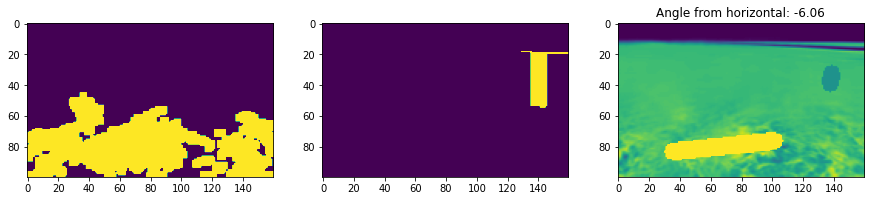

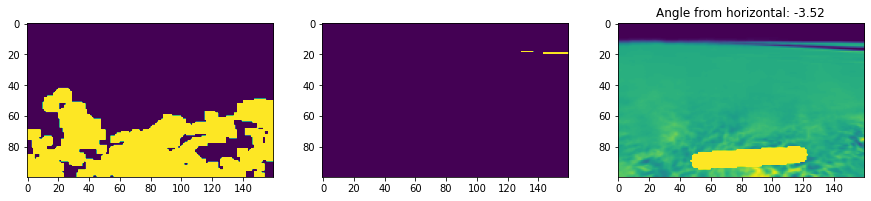

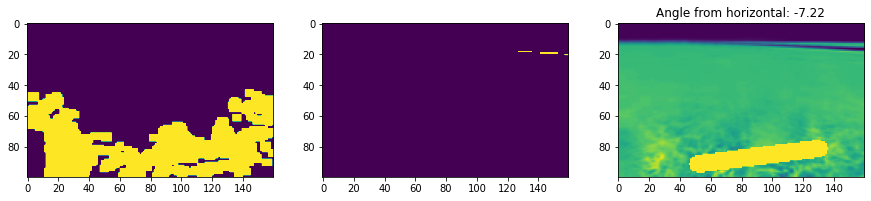

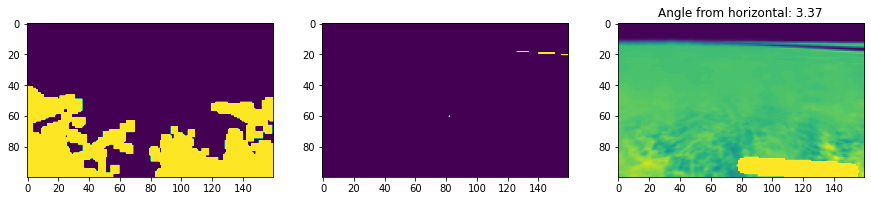

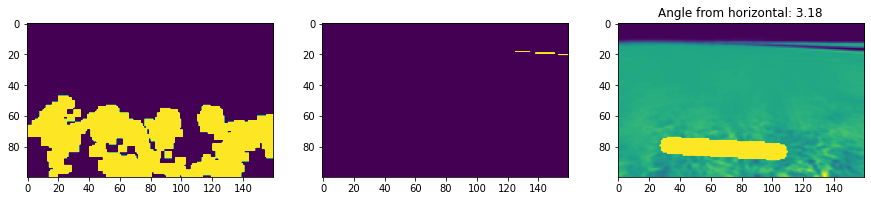

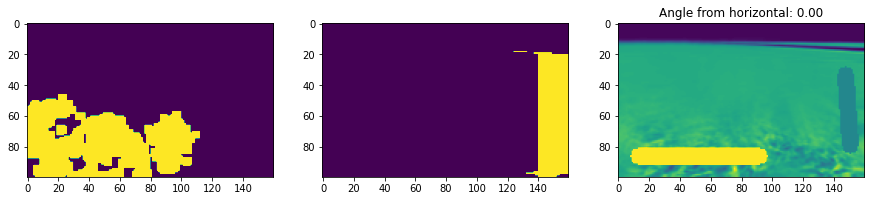

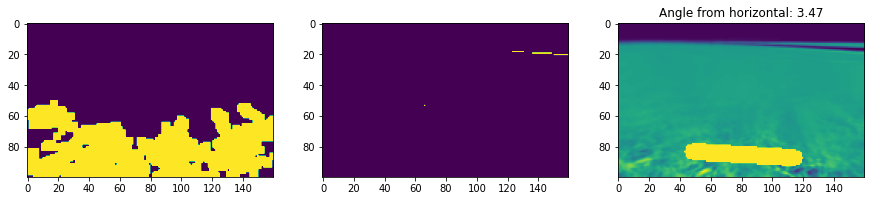

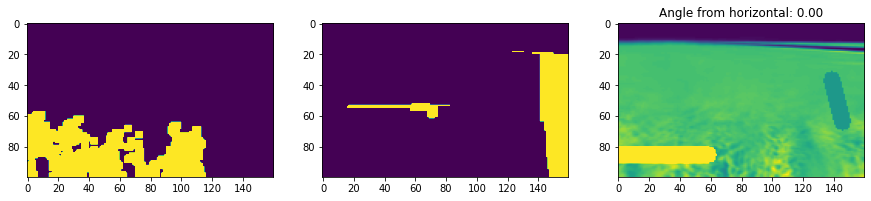

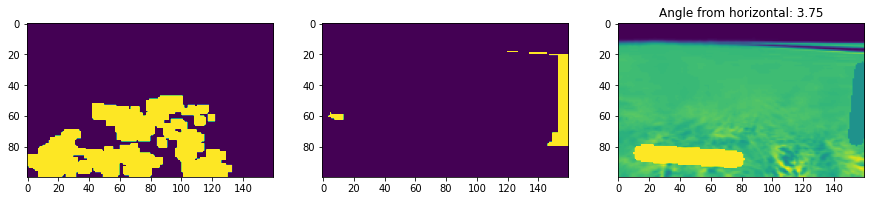

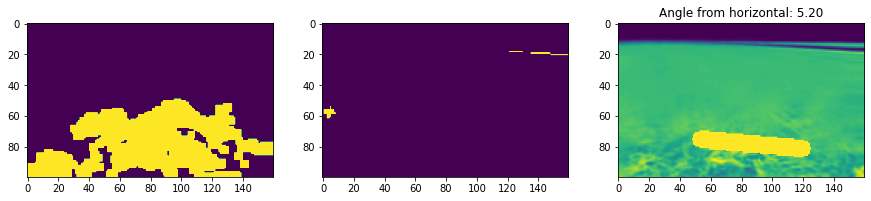

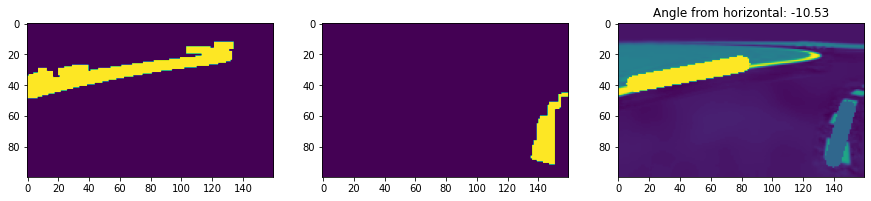

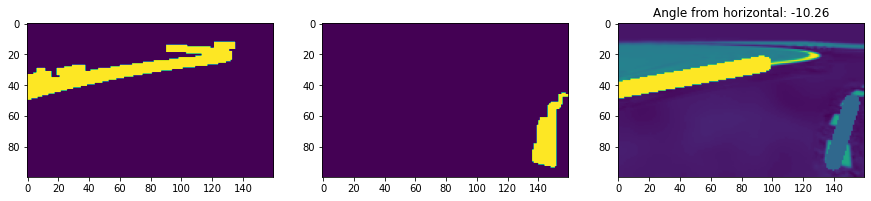

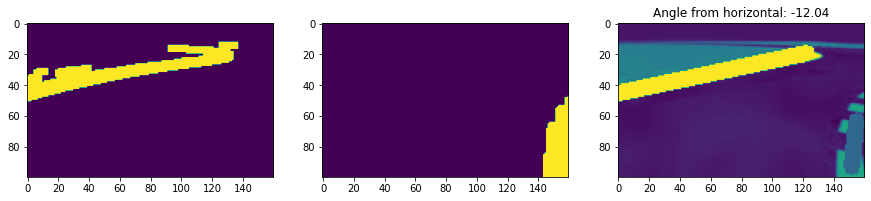

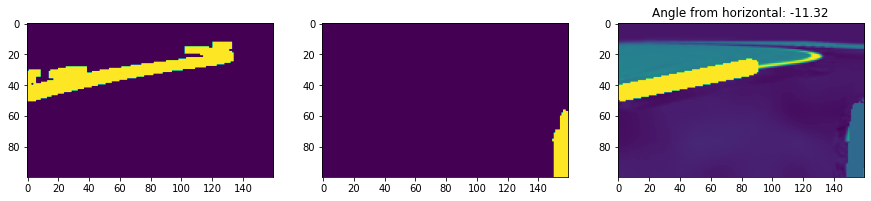

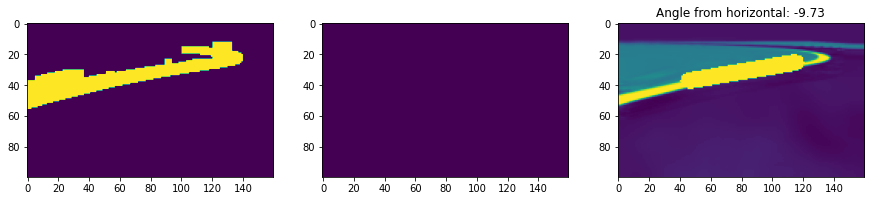

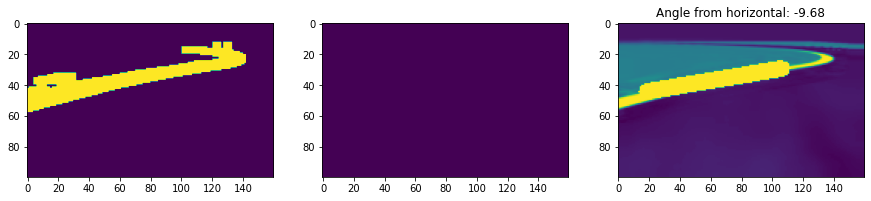

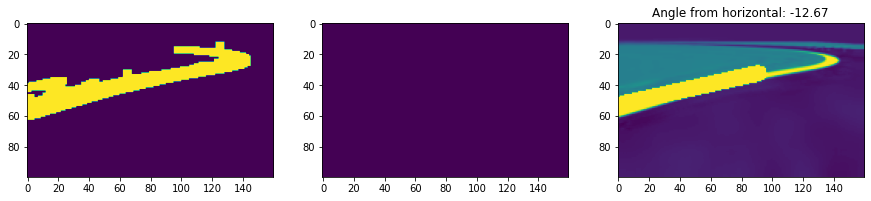

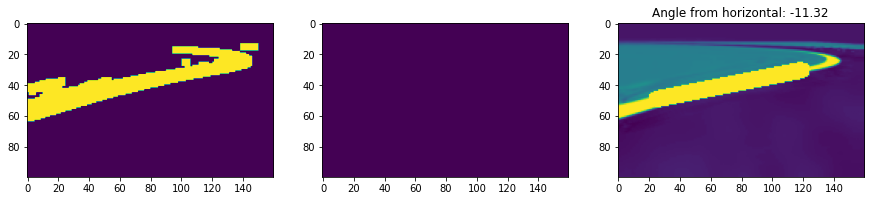

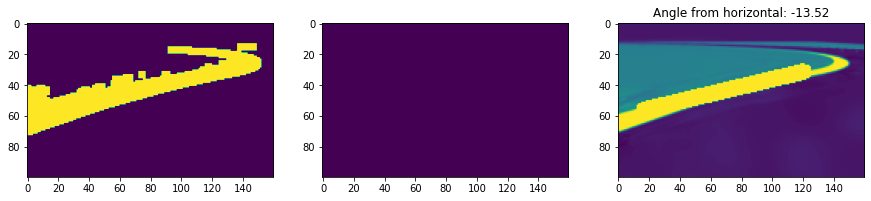

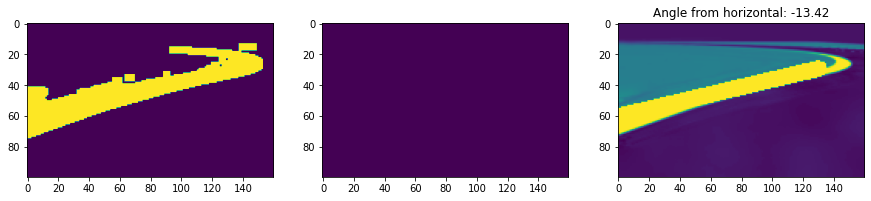

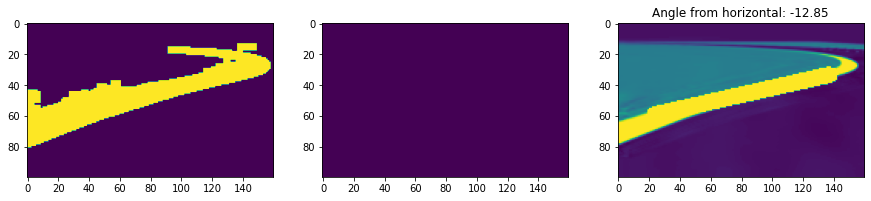

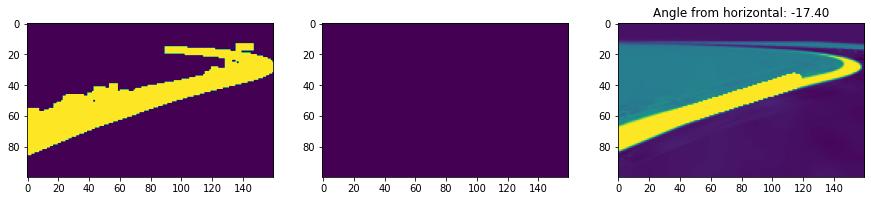

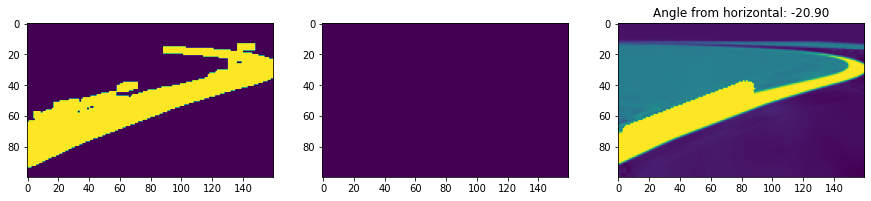

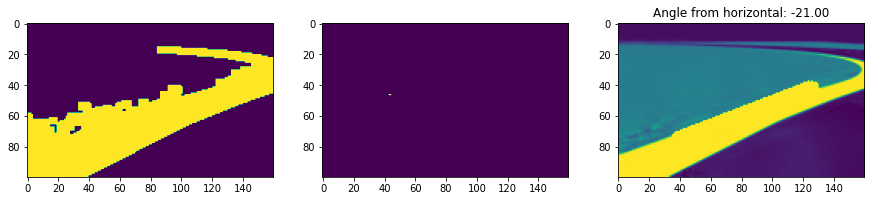

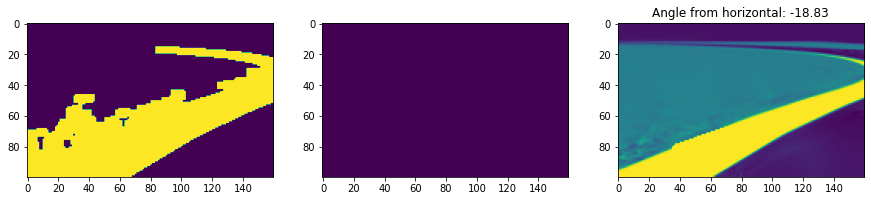

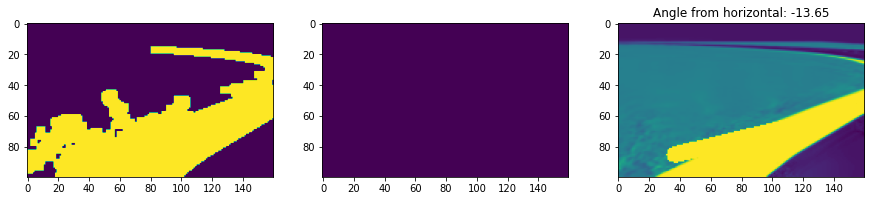

In [15]:
imgs = [cv2.fastNlMeansDenoising(cv2.imread(f'data/left_{i:04}.png', cv2.IMREAD_GRAYSCALE)[20:].astype('uint8'),20,10,21) for i in range(100,140)]

for img in imgs:
    fig, axs = plt.subplots(ncols=3, figsize=(15,10))
    img0, img1, img2 = axs[0].imshow(img), axs[1].imshow(img), axs[2].imshow(img)
    hough(img, 500, 50, 300, 30, init_thresh=150)
    plt.show()

In [16]:
def segment_img(img, init_thresh=160, denoising=False):

    
    if denoising:
        img = cv2.fastNlMeansDenoising(img.astype('uint8'),20,10,21)
        
    thresholded = (img > init_thresh).astype('uint8')*255
    
    # dilation kernel to select only rotating road on side
    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(thresholded,kernel,iterations = 1)
    long_comp = keep_long_components(dilation)
    
    # removing rest to keep only middle road
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(60,7))
    dilation3 = cv2.dilate(long_comp.astype('uint8'),kernel,iterations = 1, borderType = cv2.BORDER_REFLECT)
    center = (((thresholded - dilation3) > 1).astype('float'))
    
    # add borders so opening doesn't mess up on corners
    outputImage = cv2.copyMakeBorder(
                center, 
                 50, 
                 50, 
                 50, 
                 50, 
                 cv2.BORDER_CONSTANT, 
                 value=0
              )
    
    # apply closing
    kernel = np.ones((50,50),np.uint8)
    middle_road = cv2.morphologyEx(outputImage, cv2.MORPH_CLOSE, kernel)[50:-50, 50:-50]
    
    return long_comp.astype(float)/255, middle_road

def segment_resize(img, init_thresh=160, denoising=False, size=(16,16)):
    side, mid = segment_img(img, init_thresh=init_thresh, denoising=denoising)
    return cv2.resize(side+mid, size) > 0

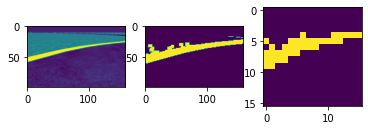

In [17]:
fig, axs = plt.subplots(ncols=3)

img = cv2.imread(f'data/left_0101.png', cv2.IMREAD_GRAYSCALE)[20:]
a,b = segment_img(img, init_thresh=160)
axs[0].imshow(img)
axs[1].imshow(a+b)
axs[2].imshow(segment_resize(img))

In [18]:
%%timeit
#imgs = [cv2.fastNlMeansDenoising(cv2.imread(f'data/left_{i:04}.png', cv2.IMREAD_GRAYSCALE)[20:].astype('uint8'),20,10,21) for i in range(178,200)]



#denoised = cv2.fastNlMeansDenoising(img[20:],20,10,21)
a,b = segment(img[20:], init_thresh=160)
resized = cv2.resize(a+b, (16,16)) > 0

NameError: name 'segment' is not defined